# Généralisation robuste de LDA/QDA

Andrew Wang

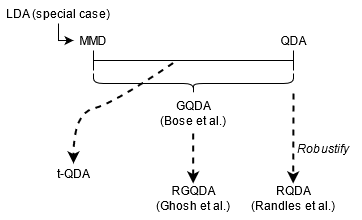

Méthodes classiques: MMD, (LDA,) QDA  
Méthodes génerales: GQDA (qui généralise le regle de classification pour les distributions ES avec la variable c qui interpole entre 0 (MMD) et 1 (QDA))  
Méthodes robustes: RQDA (utilisant le regle QDA mais avec estimation robuste - on peut compter M-estimator, MVE, MCD, S-estimator optimal(selon Croux et al.), etc  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;RGQDA  
Cas particulier: t-QDA (la variable c calculée en termes de DOFs, estimation robuste avec EM)  

QDA avec ES: estimation des parametres avec le meme EM (mais avec E-step fixé) et calculation des posteriors avec le E-step

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
from plotnine import *
from plotnine.data import *
# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis
from scipy import stats, special, optimize
from sklearn.model_selection import train_test_split
# EMBEDDINGs:
import umap
warnings.filterwarnings('ignore') # AMI warning

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from import_subset_datasets import *
from clustering_accuracy import acc
from vis import *
from dataset_utils import *
from models import *

In [4]:
from _fem import FEM

In [266]:
def run_all(X, y, X_test, y_test, slow=True):
    print("LDA")
    ldatest = LDA(method='generalised')#discriminant_analysis.LinearDiscriminantAnalysis()
    ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), ldatest.predict(X_test))
    print("QDA")
    qdatest = QDA(method='generalised')#discriminant_analysis.QuadraticDiscriminantAnalysis()
    qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qdatest.predict(X_test))
    print("t-LDA")
    t_ldatest = t_LDA(method='distributional')
    t_ldatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_ldatest.predict(X_test))
    print("t-QDA")
    t_qdatest = t_QDA(method='distributional')
    t_qdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_qdatest.predict(X_test))
    if not slow:
        return ldatest, qdatest, t_ldatest, t_qdatest
    #print("GQDA")
    #gqdatest = GQDA()
    #gqdatest.fit(X, pd.Series(y))
    #print_metrics(pd.Series(y_test), gqdatest.predict(X_test))
    """
    print("RGQDA")
    rgqdatest = RGQDA('M-estimator')
    rgqdatest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdatest.predict(X_test))
    print("RGQDA-S")
    rgqdastest = RGQDA('S-estimator')
    rgqdastest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), rgqdastest.predict(X_test))
    print("RQDA-M")
    rqdatest = RGQDA('M-estimator')
    rqdatest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdatest.predict(X_test))
    print("RQDA-S")
    rqdastest = RGQDA('S-estimator')
    rqdastest.fit(X, pd.Series(y), c=1)
    print_metrics(pd.Series(y_test), rqdastest.predict(X_test))
    """
    print("t-QDA-FEM")
    t_qda_femtest = t_QDA_FEM(method='distributional')
    t_qda_femtest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), t_qda_femtest.predict(X_test))
    print("QDA-FEM")
    qda_femtest = QDA_FEM(method='distributional')
    qda_femtest.fit(X, pd.Series(y))
    print_metrics(pd.Series(y_test), qda_femtest.predict(X_test))
    
    return ldatest, qdatest, t_ldatest, t_qdatest,  t_qda_femtest, qda_femtest #rgqdatest, rgqdastest, rqdatest, rqdastest,

In [217]:
def test_all(models, X_test, y_test, percent_outliers=0):
    for model in models:
        print(type(model).__name__)
        print_metrics(pd.Series(y_test), model.predict(X_test, percent_outliers=percent_outliers), conf=True)

In [ ]:
def evaluate_all(models):
    for model in models:
        print(type(model).__name__)
        evaluate_estimators(#print_metrics(pd.Series(y_test), model.predict(X_test, percent_outliers=percent_outliers), conf=True)    

In [209]:
class FEM_classification(FEM):
    def fit(self, X):
        pass
    def override_params(self, mu, Sigma):
        self.mu_, self.Sigma_ = mu, Sigma
    def _e_step(self, X):
        return np.ones((X.shape[0], self.K))

In [210]:
class LDA_FEM_base():
    def FEM_estimate(self, X): #X is {X: I(Zi=k|Xi=xi)=1}
        # initialise K=2 (for 1 class, but to maintain structure), tau,alpha randomly and means and sigma with Gaussian MLE
        _K = 2
        FEM_estimator = FEM_classification(_K, rand_initialization=True)
        FEM_estimator._initialize(X)
        FEM_estimator.override_params(np.repeat(X.mean(axis=0)[None,:], _K, axis=0), np.repeat(np.cov(X.T)[None,:], _K, axis=0))
        
        #run E-step to get indicators
        cond_prob = FEM_estimator._e_step(X)
        #run M-step
        FEM_estimation = FEM_estimator._m_step(X, cond_prob)  
        mean = FEM_estimation[1][0,:]; cov = FEM_estimation[2][0,:,:]
        return [mean, cov]

In [211]:
class LDA_FEM(LDA, LDA_FEM_base):
    def estimate_parameters(self, X):
        return self.FEM_estimate(X)

In [212]:
class QDA_FEM(LDA_FEM, LDA_FEM_base):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False     

In [213]:
class t_LDA_FEM(t_LDA, LDA_FEM_base):
    def estimate_parameters(self, X):
        params = self.FEM_estimate(X)
        return params + [fit_t_dof(X, *params, dof_0=3)]

In [214]:
class t_QDA_FEM(t_LDA_FEM, LDA_FEM_base):
    def __init__(self, method='distributional'):
        super().__init__(method)
        self.pool_covs = False   

In [193]:
GN_X = LaplacesDemon.rmvpe(10000, mu=np.array([0,0]), Sigma=np.eye(2), kappa=100)

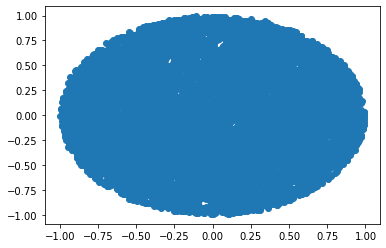

In [194]:
plt.scatter(GN_X[:,0], GN_X[:,1])

In [195]:
print(GN_X.mean(axis=0), np.cov(GN_X.T))

[-0.00355409 -0.00281847] [[0.24551788 0.00203319]
 [0.00203319 0.24863787]]


In [196]:
print(fit_t(GN_X))

(array([-0.00358463, -0.00286752]), array([[0.24488841, 0.00203166],
       [0.00203166, 0.24800387]]), array([270.18340339]))


In [197]:
print(LDA_FEM_base().FEM_estimate(GN_X))

[array([-8.49722751e-07, -1.05015515e-06]), array([[0.98931978, 0.01489019],
       [0.01489019, 1.01068022]])]


## Fashion-MNIST

### Prepare MNIST data

In [13]:
np.random.seed(44)
random.seed(44)

#read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
#read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

read_mnist_train = pd.read_csv(r"data\fashion-mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\fashion-mnist_test.csv")

In [14]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [0,2,3,4,6]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
#mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [15]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [16]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

In [17]:
ret =  lda_grid(em, mapper)
%store ret

Stored 'ret' (tuple)


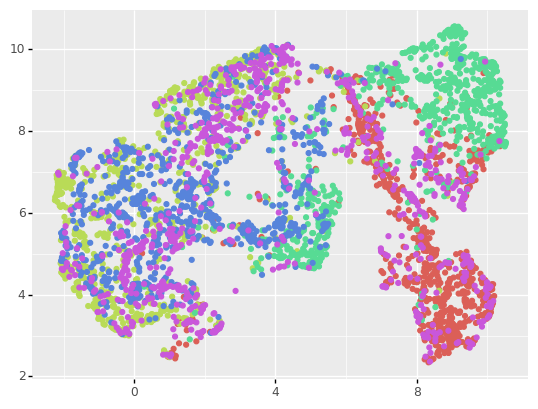

<ggplot: (182941889052)>

In [18]:
gg

### Pure MNIST

In [19]:
models_MNIST_pure = run_all(mnist_pca, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.723 ARI 0.45374 AMI 0.46753
QDA
N 2000 Accuracy 0.734 ARI 0.48004 AMI 0.48223
t-LDA
N 2000 Accuracy 0.7145 ARI 0.43086 AMI 0.45132
t-QDA
N 2000 Accuracy 0.7365 ARI 0.47754 AMI 0.48499
RGQDA
optimal c is 0.8311971646188802
N 2000 Accuracy 0.7295 ARI 0.46373 AMI 0.4717
RGQDA-S
optimal c is 0.43589705543518814
N 2000 Accuracy 0.7125 ARI 0.4273 AMI 0.44851
RQDA-M
N 2000 Accuracy 0.725 ARI 0.45994 AMI 0.46928
RQDA-S
N 2000 Accuracy 0.7105 ARI 0.43114 AMI 0.44914
t-QDA-FEM
N 1409 Accuracy 0.79986 ARI 0.58103 AMI 0.57701
QDA-FEM
N 546 Accuracy 0.58974 ARI 0.0 AMI 0.0


### MNIST with mislabelling

In [20]:
mnist_labels_mislabelled = mislabelled(800, 0.1, np.unique(mnist_labels))

In [21]:
models_MNIST_mislabelled = run_all(mnist_pca, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.725 ARI 0.45496 AMI 0.46782
QDA
N 2000 Accuracy 0.734 ARI 0.4789 AMI 0.47403
t-LDA
N 2000 Accuracy 0.7135 ARI 0.42887 AMI 0.4487
t-QDA
N 2000 Accuracy 0.742 ARI 0.48683 AMI 0.49033
RGQDA
optimal c is 0.9570321388596548
N 2000 Accuracy 0.7255 ARI 0.46184 AMI 0.4665
RGQDA-S
optimal c is 0.7705327988859793
N 2000 Accuracy 0.7145 ARI 0.43782 AMI 0.45336
RQDA-M
N 2000 Accuracy 0.7245 ARI 0.46114 AMI 0.46725
RQDA-S
N 2000 Accuracy 0.706 ARI 0.4276 AMI 0.44605
t-QDA-FEM
N 1461 Accuracy 0.79261 ARI 0.56971 AMI 0.56705
QDA-FEM
N 598 Accuracy 0.54181 ARI 0.0 AMI -0.0


### MNIST with contamination

In [22]:
mnist_pca_contaminated = contaminate_dataset(mnist_pca, 0.1)

In [23]:
models_MNIST_contaminated = run_all(mnist_pca_contaminated, mnist_labels, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.675 ARI 0.35444 AMI 0.41888
QDA
N 2000 Accuracy 0.511 ARI 0.26734 AMI 0.31593
t-LDA
N 2000 Accuracy 0.7145 ARI 0.43153 AMI 0.45156
t-QDA
N 2000 Accuracy 0.738 ARI 0.47717 AMI 0.48203
RGQDA
optimal c is 0.994049198590175
N 2000 Accuracy 0.726 ARI 0.46112 AMI 0.4669
RGQDA-S
optimal c is 0.7334635446685435
N 2000 Accuracy 0.715 ARI 0.44054 AMI 0.45711
RQDA-M
N 2000 Accuracy 0.726 ARI 0.46112 AMI 0.4669
RQDA-S
N 2000 Accuracy 0.707 ARI 0.43125 AMI 0.45079
t-QDA-FEM
N 1419 Accuracy 0.80268 ARI 0.58341 AMI 0.58075
QDA-FEM
N 598 Accuracy 0.54181 ARI 0.0 AMI -0.0


### MNIST with contamination and mislabelling

In [267]:
models_MNIST_contaminated_mislabelled = run_all(mnist_pca_contaminated, mnist_labels_mislabelled, mnist_test_pca, mnist_test_labels)

LDA
N 2000 Accuracy 0.5915 ARI 0.27353 AMI 0.32689
QDA
N 2000 Accuracy 0.525 ARI 0.26312 AMI 0.30548
t-LDA
N 2000 Accuracy 0.58 ARI 0.29858 AMI 0.34158
t-QDA
N 2000 Accuracy 0.651 ARI 0.34719 AMI 0.38013
t-QDA-FEM
N 2000 Accuracy 0.6515 ARI 0.35053 AMI 0.38505
QDA-FEM
N 2000 Accuracy 0.352 ARI 0.0 AMI -0.0


### MNIST contaminated test labels

In [273]:
mnist_test_pca_c, contam_ind = contaminate_dataset(mnist_test_pca, 0.1)
test_all(models_MNIST_contaminated_mislabelled, mnist_test_pca_c, apply_outlierness(contam_ind, mnist_test_labels), percent_outliers=0.1)

(2000,) (2000,)
LDA
N 2000 Accuracy 0.5725 ARI 0.18625 AMI 0.29715
[[180  83 113 124 119  72]
 [  5 181  10  17   7  65]
 [  2   0 167   0  42  27]
 [  4   3   4 186  20  31]
 [  3   0  34  10 181  38]
 [  4  26  28   3  37 174]]
QDA
N 2000 Accuracy 0.5425 ARI 0.20986 AMI 0.30097
[[158  16 130  88  51 248]
 [ 21 215   4  20   2  23]
 [  3  82  30  11 105   7]
 [  7  16   1 218   2   4]
 [  8  27   8  37 178   8]
 [  1 128   7  34  65  37]]
t_LDA
N 2000 Accuracy 0.5315 ARI 0.28274 AMI 0.34279
[[147  74   0 428   0  42]
 [ 12 202   7  38   1  25]
 [  4   5 144  24  36  25]
 [  4   3   2 211  14  14]
 [ 19   1  19  40 160  27]
 [ 12  33  28  22  32 145]]
t_QDA
N 2000 Accuracy 0.628 ARI 0.22502 AMI 0.33308
[[180  84 105 114  92 116]
 [  4 215   4  23   2  37]
 [  2   4 170   7  29  26]
 [  3  11   1 221   7   5]
 [  5   1  11  23 196  30]
 [  3  58  15   8  33 155]]
t_QDA_FEM
N 2000 Accuracy 0.6285 ARI 0.22779 AMI 0.33826
[[183  84 103 107 104 110]
 [  4 214   4  23   2  38]
 [  2   2 172 

## Sklearn discriminant analysis

### Sklearn LDA

In [ ]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), lda.predict(mnist_test_pca))

In [ ]:
plot_contours_UMAP(gg, lda, *ret)

In [ ]:
plot_regions_UMAP(gg, lda, *ret)

### Sklearn QDA

In [ ]:
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(mnist_pca, label)
print_metrics(pd.Series(mnist_test_labels), qda.predict(mnist_test_pca))

## Synthetic Data setup 1

In [26]:
np.random.seed(seed=233423)

In [27]:
means_pure = np.array([[1, 1, 1, 1, 1, 1 ], [-1,-1,-1, 1, 1, 1], [1, 1, 1, -1,-1,-1], [-1,-1,-1,-1,-1,-1]])

In [274]:
def synthesise(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=means_pure[0,:], shape=np.eye(6), df=1, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=means_pure[1,:], shape=np.eye(6), df=3, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means_pure[2,:], shape=np.eye(6), df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=means_pure[3,:], shape=np.eye(6), df=1, hard=hard) #cauchy
    
    return np.vstack([X1, X2, X3, X4]), apply_outlierness([o1,o2,o3,o4], mislabelled(n, mislabelling, np.arange(4)))

In [275]:
X_test,y_test = synthesise(1000)

(4000,) (4000,)


### Synthetic data pure

In [276]:
X,y = synthesise(1000, contamination=0, mislabelling=0)

(4000,) (4000,)


In [277]:
models_synth_pure = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.69425 ARI 0.37042 AMI 0.36035
QDA
N 4000 Accuracy 0.54275 ARI 0.27716 AMI 0.31685
t-LDA
N 4000 Accuracy 0.826 ARI 0.59803 AMI 0.5539
t-QDA
N 4000 Accuracy 0.82275 ARI 0.59154 AMI 0.5487
t-QDA-FEM
N 4000 Accuracy 0.824 ARI 0.59451 AMI 0.55101
QDA-FEM
N 4000 Accuracy 0.79 ARI 0.52627 AMI 0.48846


### Synthetic data with mislabelling

In [278]:
X,y = synthesise(1000, contamination=0, mislabelling=0.1)

(4000,) (4000,)


In [279]:
models_synth_mislabelling = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.70125 ARI 0.38171 AMI 0.37028
QDA
N 4000 Accuracy 0.53 ARI 0.2553 AMI 0.29218
t-LDA
N 4000 Accuracy 0.82425 ARI 0.59419 AMI 0.54903
t-QDA
N 4000 Accuracy 0.82175 ARI 0.58905 AMI 0.5436
t-QDA-FEM
N 4000 Accuracy 0.82175 ARI 0.58885 AMI 0.54258
QDA-FEM
N 4000 Accuracy 0.794 ARI 0.53283 AMI 0.49223


### Synthetic data with contamination

In [280]:
X,y = synthesise(1000, contamination=0.1, mislabelling=0)

(4000,) (4000,)


In [281]:
models_synth_contamination = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.74275 ARI 0.43964 AMI 0.41084
QDA
N 4000 Accuracy 0.5435 ARI 0.27901 AMI 0.31918
t-LDA
N 4000 Accuracy 0.55575 ARI 0.22212 AMI 0.26144
t-QDA
N 4000 Accuracy 0.817 ARI 0.58258 AMI 0.53229
t-QDA-FEM
N 4000 Accuracy 0.808 ARI 0.57208 AMI 0.52636
QDA-FEM
N 4000 Accuracy 0.7835 ARI 0.51807 AMI 0.47825


### Synthetic data with contamination and mislabelling

In [282]:
X,y = synthesise(1000, contamination=0.1, mislabelling=0.1)

(4000,) (4000,)


In [283]:
models_synth_contamination_mislabelling = run_all(X,y,X_test,y_test)

LDA
N 4000 Accuracy 0.64125 ARI 0.28336 AMI 0.27042
QDA
N 4000 Accuracy 0.53125 ARI 0.25275 AMI 0.28538
t-LDA
N 4000 Accuracy 0.588 ARI 0.23999 AMI 0.25318
t-QDA
N 4000 Accuracy 0.8155 ARI 0.57885 AMI 0.52975
t-QDA-FEM
N 4000 Accuracy 0.80425 ARI 0.56664 AMI 0.51492
QDA-FEM
N 4000 Accuracy 0.778 ARI 0.51129 AMI 0.46715


### Synthetic data with test contamination

In [285]:
X_test_c,y_test_c = synthesise(1000, contamination=0.1, mislabelling=0)

(4000,) (4000,)


In [286]:
test_all(models_synth_contamination_mislabelling,X_test_c,y_test_c, percent_outliers=0.1)

LDA
N 4000 Accuracy 0.65275 ARI 0.27856 AMI 0.27513
[[219  55  34  32  60]
 [ 99 524 161  80  36]
 [ 74  83 641  52  50]
 [  2 106 105 637  50]
 [102  43 223 104 428]]
QDA
N 4000 Accuracy 0.548 ARI 0.2834 AMI 0.31703
[[201 187   0   0  12]
 [183 108 413 180  16]
 [ 41  15 820  24   0]
 [ 36   0  42 822   0]
 [201  75 380 216  28]]
t_LDA
N 4000 Accuracy 0.597 ARI 0.21199 AMI 0.23716
[[141 103  39   1 116]
 [227 359  50 182  82]
 [271  33 478  72  46]
 [140  48   2 660  50]
 [217  32  68 166 417]]
t_QDA
N 4000 Accuracy 0.82225 ARI 0.55149 AMI 0.54037
[[392   1   0   0   7]
 [129 638  43  34  56]
 [ 56  73 691   9  71]
 [ 60  32   9 773  26]
 [134  39  42  31 654]]
t_QDA_FEM
N 4000 Accuracy 0.809 ARI 0.51602 AMI 0.49039
[[296  31   0   0  73]
 [108 651  43  36  62]
 [ 83  79 656   9  73]
 [ 61  31  10 775  23]
 [128  44  42  29 657]]
QDA_FEM
N 4000 Accuracy 0.79475 ARI 0.50145 AMI 0.48619
[[350  20   1   2  27]
 [129 602  65  77  27]
 [ 46  80 686  20  68]
 [  7  50   8 799  36]
 [128  23

## Synthetic data setup 2 (for visualisation)

In [241]:
%run dataset_utils

In [242]:
def synthesise2d(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    X1,o1 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([2 , 2]), shape=np.eye(2), df=1, hard=hard) #cauchy
    X2,o2 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-2, 2]), shape=np.eye(2), df=3, hard=hard) #t
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([2 ,-2]), shape=np.eye(2), df=20, hard=hard) #normal
    X4,o4 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([-2,-2]), shape=np.eye(2), df=1, hard=hard) #cauchy
    X5,o5 = contaminated(n, stats.multivariate_t, contamination, loc=np.array([2 , 6]), shape=np.eye(2), df=1, hard=hard) #cauchy
    
    return np.vstack([X1, X2, X3, X4, X5]), apply_outlierness([o1,o2,o3,o4,o5], mislabelled(n, mislabelling, np.arange(5)))

In [224]:
X_test_2d,y_test_2d = synthesise2d(100)

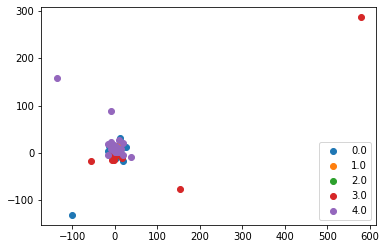

In [227]:
ax = plt.figure().gca()
#plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)
plt.legend()

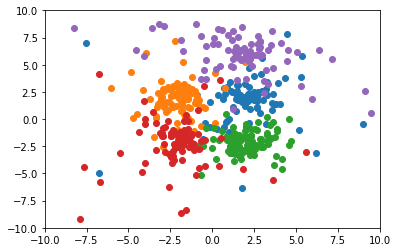

In [228]:
ax = plt.figure().gca()
plt.xlim([-10,10]); plt.ylim([-10,10])
plot_dataset(X_test_2d, y_test_2d, ax)

### Pure dataset

In [229]:
X_2d,y_2d = synthesise2d(100, contamination=0, mislabelling=0)

In [230]:
models_vis_pure = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.76 ARI 0.49931 AMI 0.50106
QDA
N 500 Accuracy 0.554 ARI 0.33076 AMI 0.37002
t-LDA
N 500 Accuracy 0.818 ARI 0.60618 AMI 0.598
t-QDA
N 500 Accuracy 0.812 ARI 0.59486 AMI 0.59654
RGQDA
optimal c is 0.0
N 500 Accuracy 0.756 ARI 0.46616 AMI 0.55893
RGQDA-S
optimal c is 0.0
N 500 Accuracy 0.752 ARI 0.46933 AMI 0.53556
RQDA-M
N 500 Accuracy 0.784 ARI 0.54052 AMI 0.56176
RQDA-S
N 500 Accuracy 0.776 ARI 0.5259 AMI 0.55079
t-QDA-FEM
N 500 Accuracy 0.826 ARI 0.6226 AMI 0.6116
QDA-FEM
N 500 Accuracy 0.816 ARI 0.60452 AMI 0.5988


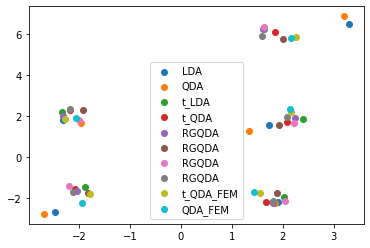

In [231]:
plot_means(models_vis_pure)

In [232]:
approx_tQDA_test_pure = t_QDA(method='generalised')
approx_tQDA_test_pure.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), approx_tQDA_test_pure.predict(X_test_2d))

N 500 Accuracy 0.77 ARI 0.51191 AMI 0.54422


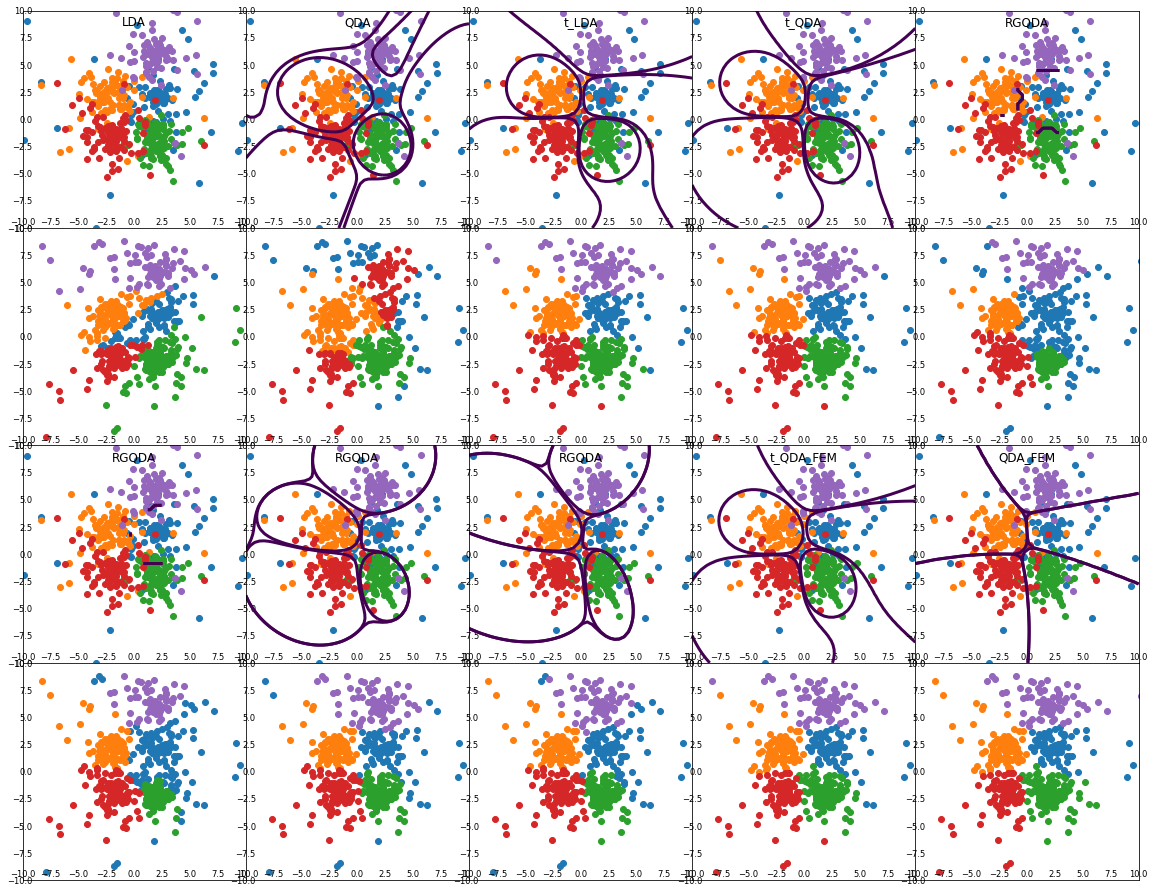

In [233]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_pure)#+(approx_tQDA_test_pure,))

### Dataset with test contamination

In [251]:
X_test_c_2d,y_test_c_2d = synthesise2d(100, contamination=0.1)

(500,) (500,)


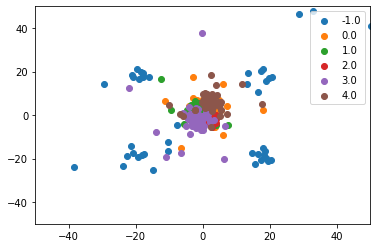

In [252]:
ax = plt.figure().gca()
plt.xlim([-50,50]); plt.ylim([-50,50])
plot_dataset(X_test_c_2d, y_test_c_2d, ax)
plt.legend()

In [253]:
test_all(models_vis_pure,X_test_c_2d,y_test_c_2d, percent_outliers=0.05)

LDA
N 500 Accuracy 0.706 ARI 0.38227 AMI 0.40063
[[ 8  0  0 12  7 23]
 [ 6 53 12 10  1  8]
 [ 1 12 67  2  3  5]
 [ 0  3  0 81  6  0]
 [ 3  9  8 19 48  3]
 [ 5  5  8  4  0 68]]
QDA
N 500 Accuracy 0.568 ARI 0.37876 AMI 0.42227
[[ 4  7  0  0  2 37]
 [ 7 20 28  8 24  3]
 [ 1  4 83  0  1  1]
 [ 5  1  1 82  1  0]
 [ 3  4 19  8 51  5]
 [ 3 21  3  0 59  4]]
t_LDA
N 500 Accuracy 0.772 ARI 0.51179 AMI 0.51325
[[ 6 21  0  0  1 22]
 [ 4 61  8  6  3  8]
 [ 3  2 72  0 11  2]
 [ 1  2  0 84  3  0]
 [ 5  6  5  5 66  3]
 [ 4 11  2  0  2 71]]
t_QDA
N 500 Accuracy 0.718 ARI 0.52698 AMI 0.54974
[[ 2 47  0  0  1  0]
 [ 5 61 10  6  2  6]
 [ 5  2 73  0  9  1]
 [ 1  2  0 83  4  0]
 [ 5  9  5  4 66  1]
 [ 4 11  2  1  2 70]]
RGQDA
N 500 Accuracy 0.642 ARI 0.31996 AMI 0.44291
[[ 3 47  0  0  0  0]
 [ 5 73  5  2  2  3]
 [ 1 16 65  0  6  2]
 [ 3 31  0 52  4  0]
 [ 4 16  3  3 63  1]
 [ 6 22  2  0  1 59]]
RGQDA
N 500 Accuracy 0.658 ARI 0.35732 AMI 0.46244
[[ 3 47  0  0  0  0]
 [ 6 71  6  2  2  3]
 [ 3  9 70  0  7  1]


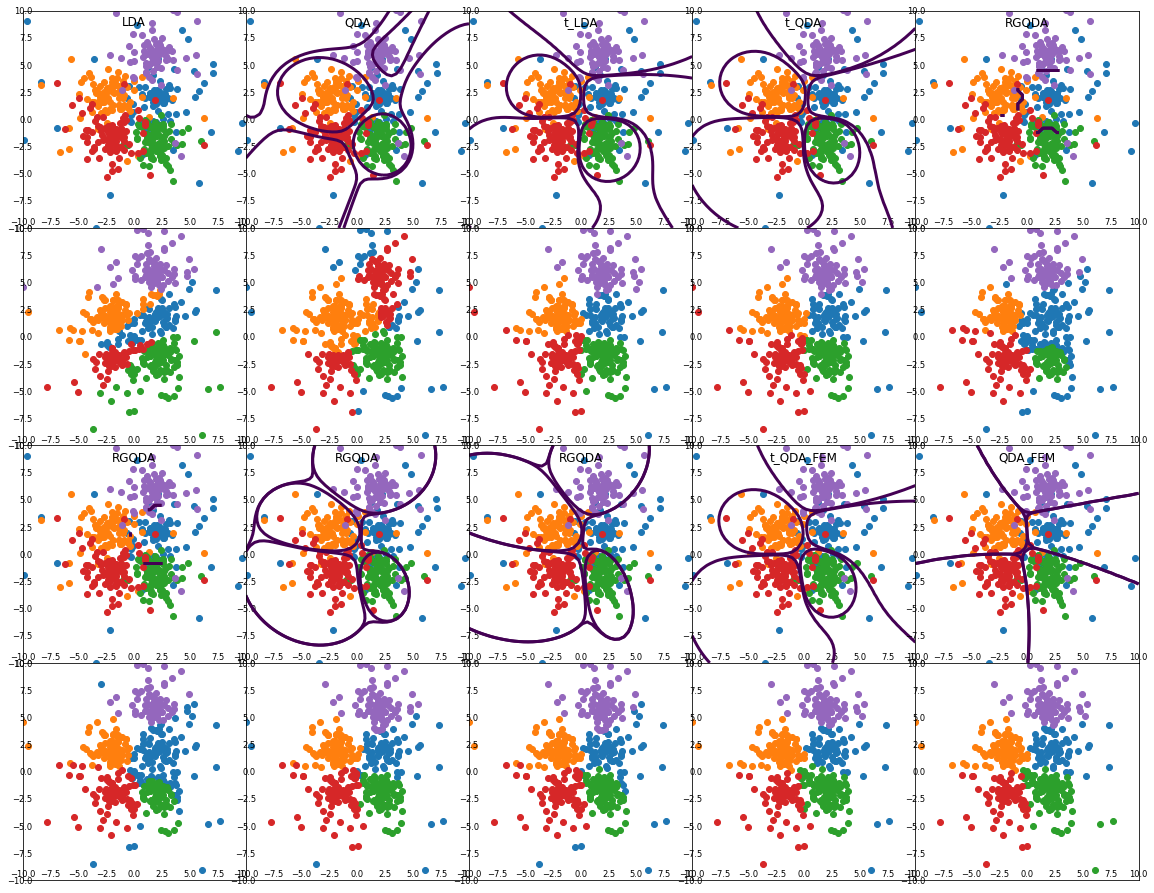

In [254]:
plot_models(X_2d, y_2d, X_test_c_2d, models_vis_pure)

### Dataset with mislabelling

In [53]:
X_2d,y_2d = synthesise2d(100, contamination=0, mislabelling=0.1)

In [54]:
models_vis_mislabelling = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.762 ARI 0.51428 AMI 0.51002
QDA
N 500 Accuracy 0.584 ARI 0.35021 AMI 0.40978
t-LDA
N 479 Accuracy 0.82255 ARI 0.61868 AMI 0.59777
t-QDA
N 482 Accuracy 0.8195 ARI 0.61214 AMI 0.58626
RGQDA
optimal c is 0.8680319420886136
N 493 Accuracy 0.80527 ARI 0.582 AMI 0.55731
RGQDA-S
optimal c is 0.0
N 493 Accuracy 0.76268 ARI 0.49935 AMI 0.5197
RQDA-M
N 495 Accuracy 0.8 ARI 0.5743 AMI 0.55472
RQDA-S
N 494 Accuracy 0.81377 ARI 0.59913 AMI 0.57432
t-QDA-FEM
N 473 Accuracy 0.81607 ARI 0.61166 AMI 0.58382
QDA-FEM
N 465 Accuracy 0.8129 ARI 0.60192 AMI 0.58136


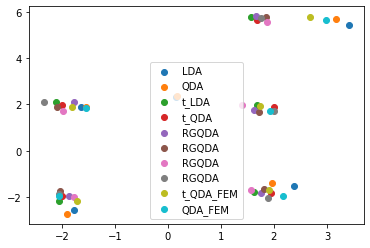

In [55]:
plot_means(models_vis_mislabelling)

In [56]:
approx_tQDA_test_mislabelling = t_QDA(method='generalised')
approx_tQDA_test_mislabelling.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), approx_tQDA_test_mislabelling.predict(X_test_2d))

N 481 Accuracy 0.81289 ARI 0.60254 AMI 0.58417


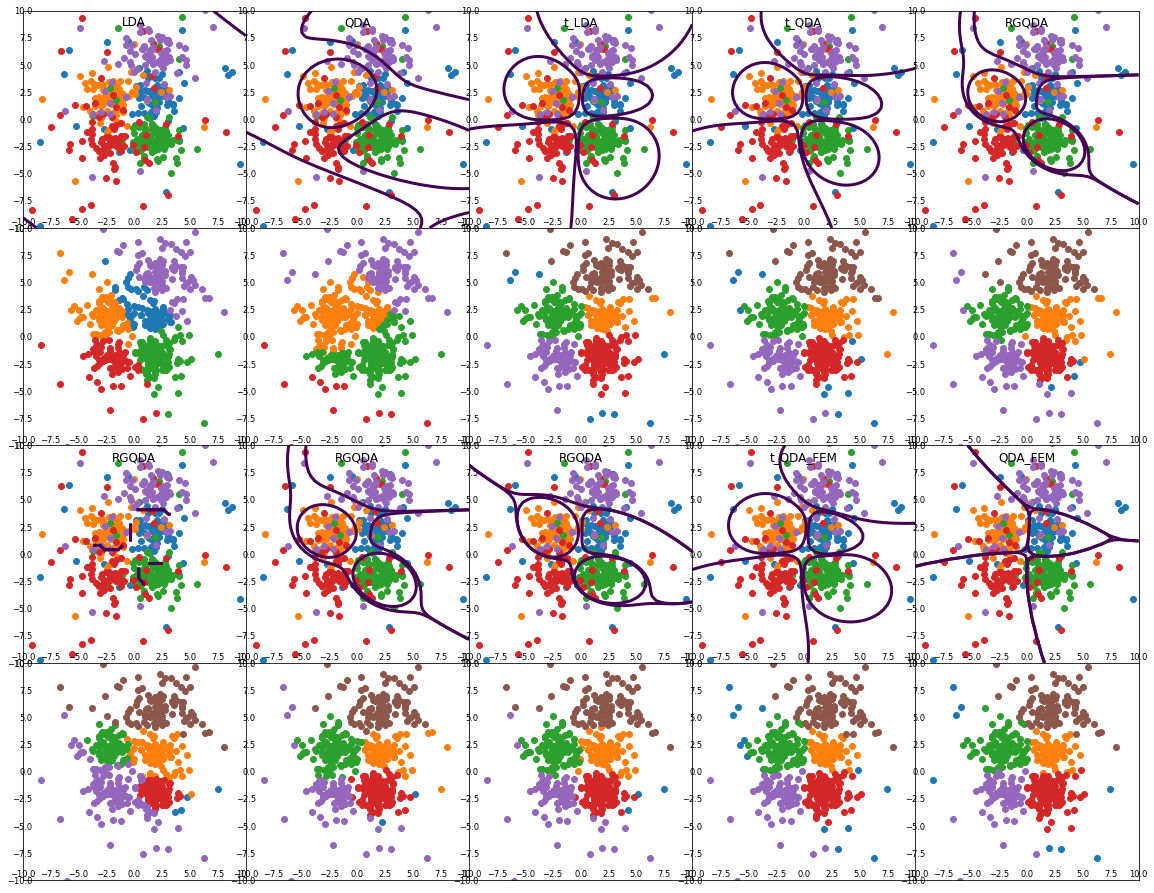

In [57]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_mislabelling)#+(approx_tQDA_test_mislabelling,))

### Dataset with contamination

In [58]:
X_2d,y_2d = synthesise2d(100, contamination=0.1, mislabelling=0)

In [59]:
models_vis_contamination = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.684 ARI 0.40364 AMI 0.42635
QDA
N 500 Accuracy 0.568 ARI 0.31023 AMI 0.36299
t-LDA
N 471 Accuracy 0.82803 ARI 0.62775 AMI 0.60655
t-QDA
N 476 Accuracy 0.81303 ARI 0.59909 AMI 0.57702
RGQDA
optimal c is 0.0
N 494 Accuracy 0.73482 ARI 0.44039 AMI 0.49072
RGQDA-S
optimal c is 0.0
N 490 Accuracy 0.76939 ARI 0.50922 AMI 0.5214
RQDA-M
N 496 Accuracy 0.78629 ARI 0.55092 AMI 0.5465
RQDA-S
N 490 Accuracy 0.81837 ARI 0.60801 AMI 0.59091
t-QDA-FEM
N 480 Accuracy 0.825 ARI 0.62029 AMI 0.59395
QDA-FEM
N 468 Accuracy 0.82265 ARI 0.61749 AMI 0.59512


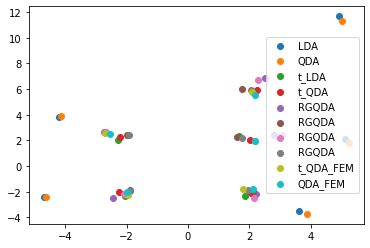

In [60]:
plot_means(models_vis_contamination)

In [61]:
approx_tQDA_test_contamination = t_QDA(method='generalised')
approx_tQDA_test_contamination.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), approx_tQDA_test_contamination.predict(X_test_2d))

N 482 Accuracy 0.79876 ARI 0.57148 AMI 0.55827


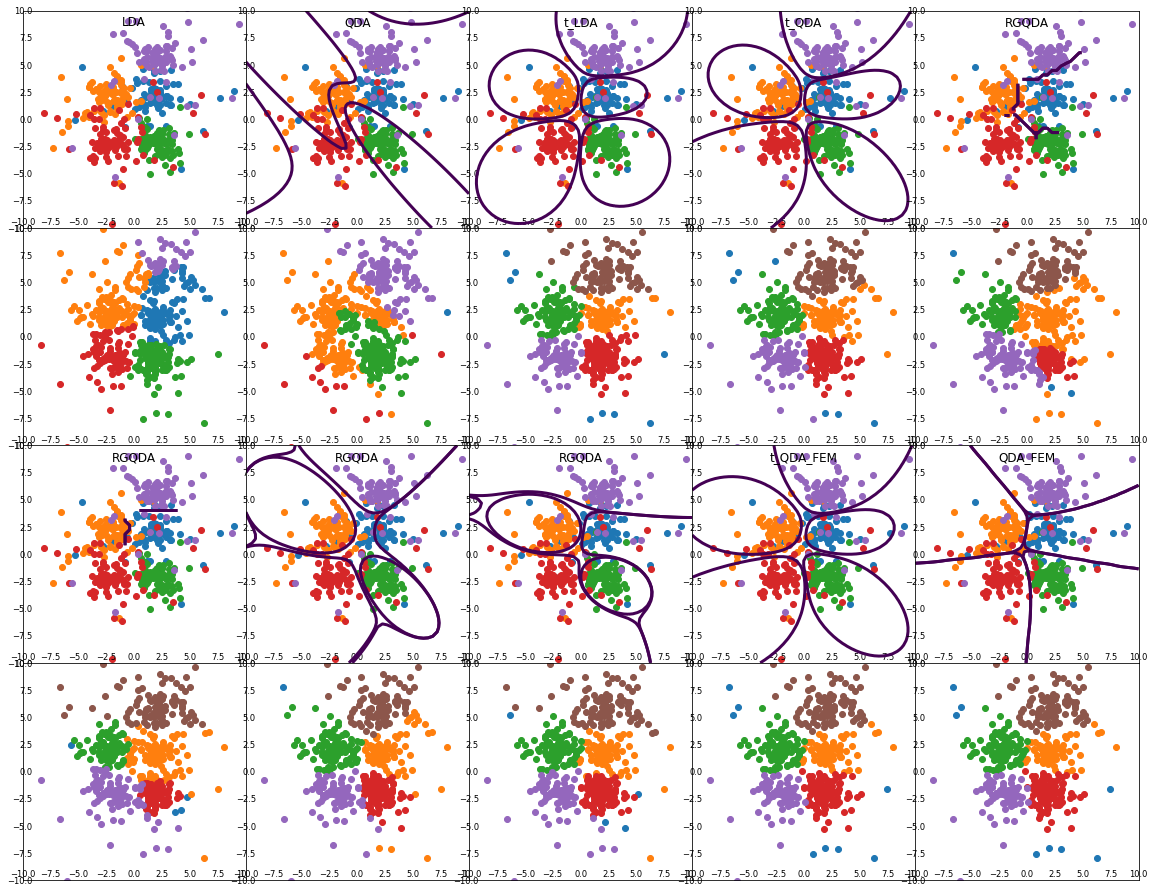

In [62]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_contamination)#+(approx_tQDA_test_contamination,))

### Dataset with mislabelling and contamination

In [63]:
X_2d,y_2d = synthesise2d(100, contamination=0.1, mislabelling=0.1)

In [64]:
models_vis_mislabelling_contamination = run_all(X_2d,y_2d,X_test_2d,y_test_2d)

LDA
N 500 Accuracy 0.452 ARI 0.17452 AMI 0.24783
QDA
N 500 Accuracy 0.458 ARI 0.25488 AMI 0.32576
t-LDA
N 477 Accuracy 0.81761 ARI 0.6082 AMI 0.58816
t-QDA
N 483 Accuracy 0.80538 ARI 0.5836 AMI 0.5658
RGQDA
optimal c is 0.398213374592182
N 493 Accuracy 0.77485 ARI 0.52699 AMI 0.52556
RGQDA-S
optimal c is 0.0
N 488 Accuracy 0.77869 ARI 0.52417 AMI 0.53633
RQDA-M
N 492 Accuracy 0.78455 ARI 0.55399 AMI 0.55165
RQDA-S
N 488 Accuracy 0.80123 ARI 0.5819 AMI 0.57519
t-QDA-FEM
N 478 Accuracy 0.79498 ARI 0.56412 AMI 0.55219
QDA-FEM
N 473 Accuracy 0.80338 ARI 0.58045 AMI 0.56389


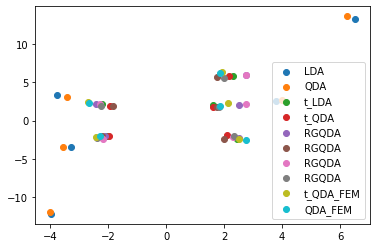

In [65]:
plot_means(models_vis_mislabelling_contamination)

In [66]:
approx_tQDA_test_mislabelling_contamination = t_QDA(method='generalised')
approx_tQDA_test_mislabelling_contamination.fit(X_2d, pd.Series(y_2d))
print_metrics(pd.Series(y_test_2d), approx_tQDA_test_mislabelling_contamination.predict(X_test_2d))

N 471 Accuracy 0.80042 ARI 0.5736 AMI 0.55969


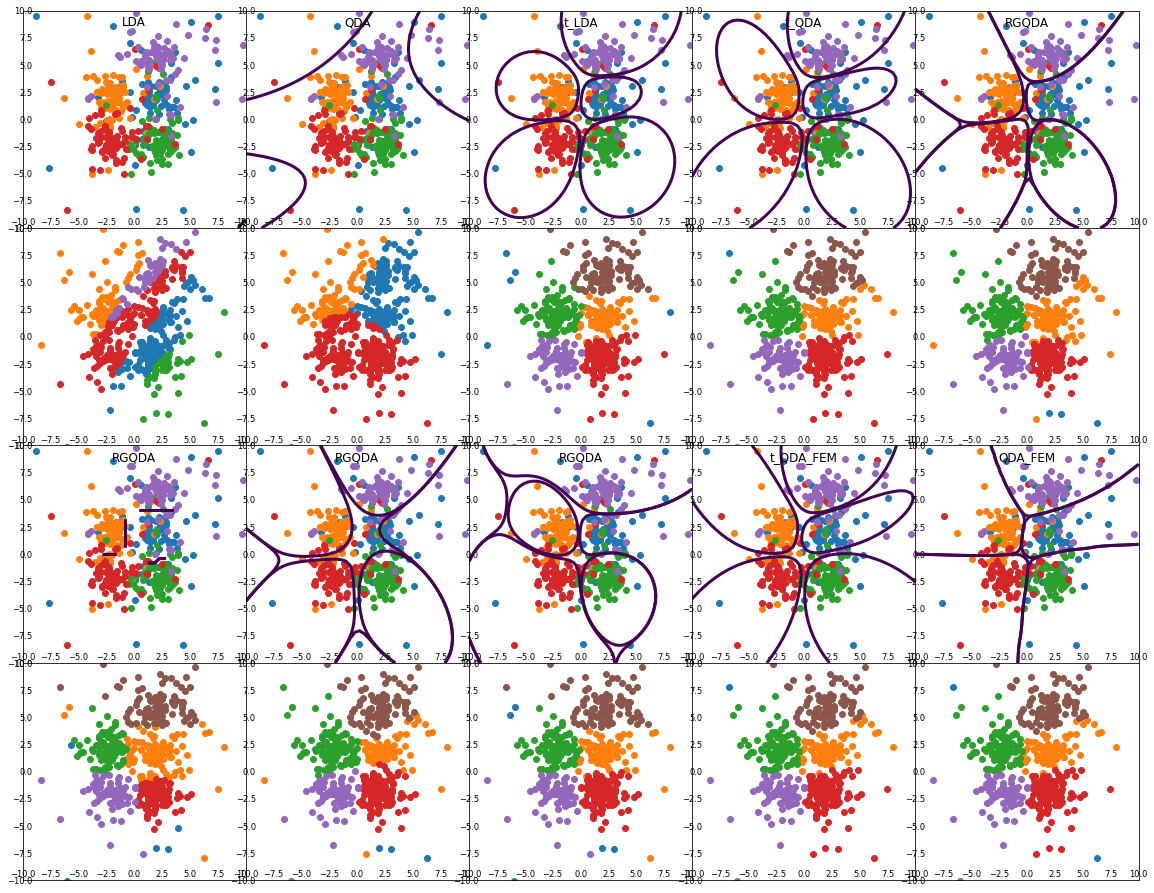

In [67]:
plot_models(X_2d, y_2d, X_test_2d, models_vis_mislabelling_contamination)#+(approx_tQDA_test_mislabelling_contamination,))

In [ ]:
plot_models(X_2d, y_2d, X_test_2d, test)

## Synthetic data setup 3

In [293]:
%run dataset_utils

In [294]:
def synthesise3(n, contamination=0, mislabelling=0): #contamination, mislabelling percent
    hard = False
    p = 2
    means = [np.zeros((p)), -20*np.ones((p)), 20*np.ones((p))]
    covs = [np.eye(p), np.eye(p), np.eye(p)]#[toeplitz(0.4, p), np.eye(p), toeplitz(0.7, p)]
    
    
    X1a = LaplacesDemon.rmvpe(n, mu=means[0], Sigma=covs[0], kappa=1) #Generalised Gaussian
    o1a = np.zeros((n))>0
    X1b,o1b = contaminated(n, stats.multivariate_t, contamination, loc=means[0], shape=covs[0], df=20, hard=hard) # Gaussian
    X1 = combine_dataset(X1a,X1b,0.3)
    o1 = combine_dataset(o1a, o1b, 0.3)
    
    X2a = LaplacesDemon.rmvpe(n, mu=means[1], Sigma=covs[1], kappa=1) #Generalised Gaussian
    o2a =np.zeros((n))>0
    X2b,o2b = contaminated(n, stats.multivariate_t, contamination, loc=means[2], shape=covs[2], df=20, hard=hard) #Gaussian
    X2 = combine_dataset(X2a,X2b,0.3)
    o2 = combine_dataset(o1a, o1b, 0.3)
    
    #X2 = contaminated(n, stats.multivariate_t, contamination, loc=, shape=, df=2.3, hard=hard) #t
    
    X3,o3 = contaminated(n, stats.multivariate_t, contamination, loc=means[0], shape=covs[0], df=1.5, hard=hard) #t
    
    return np.vstack([X1, X2, X3]), apply_outlierness([o1,o2,o3], mislabelled(n, mislabelling, np.arange(3)))

In [295]:
X3_test,y3_test = synthesise3(500, contamination=0.05)

(1500,) (1500,)


In [296]:
X3,y3 = synthesise3(1000, contamination=0.05, mislabelling=0.05)

(3000,) (3000,)


In [297]:
models_synth3_pure = run_all(X3,y3,X3_test,y3_test)

LDA
N 1500 Accuracy 0.56333 ARI 0.22664 AMI 0.30289
QDA
N 1500 Accuracy 0.714 ARI 0.51771 AMI 0.59336
t-LDA
N 1500 Accuracy 0.40067 ARI 0.03201 AMI 0.05228
t-QDA
N 1500 Accuracy 0.72067 ARI 0.47301 AMI 0.50936
t-QDA-FEM
N 1500 Accuracy 0.71733 ARI 0.49237 AMI 0.50766
QDA-FEM
N 1500 Accuracy 0.58267 ARI 0.29863 AMI 0.38528


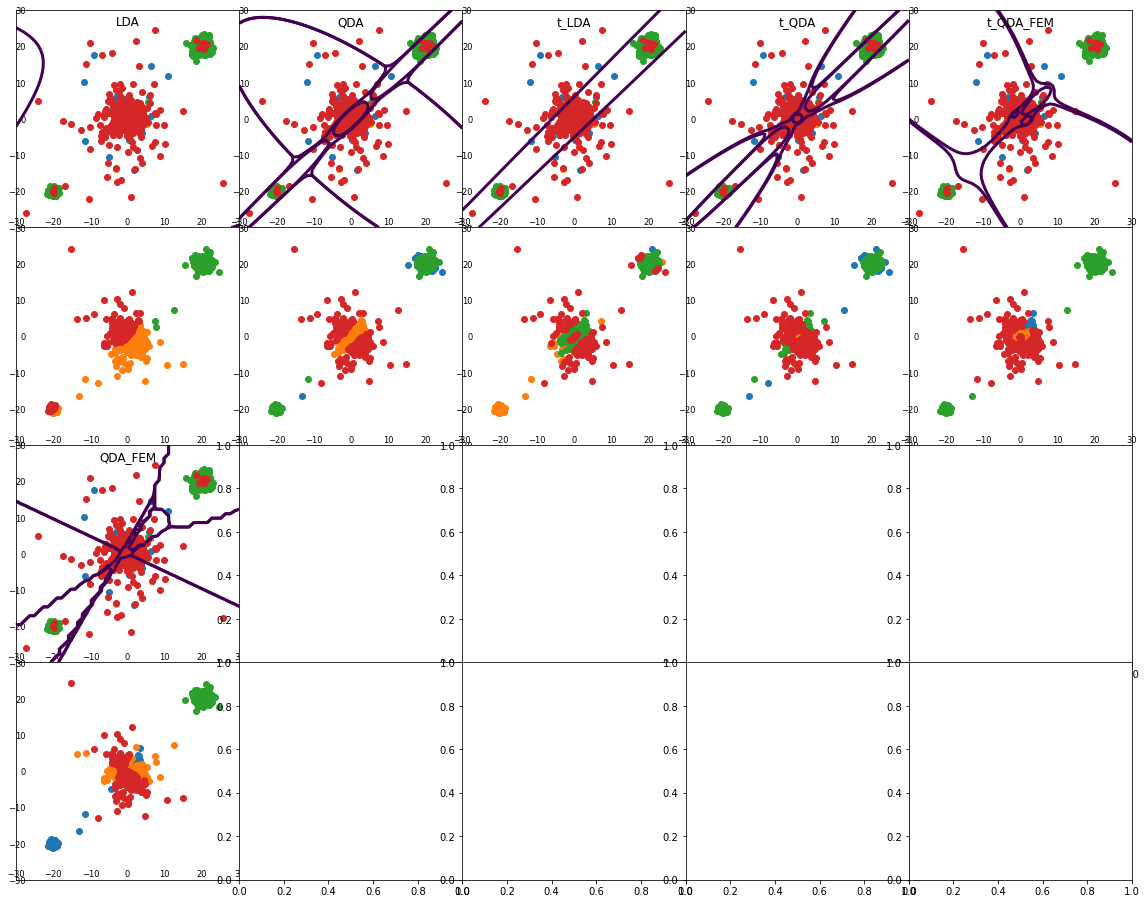

In [298]:
plot_models(X3, y3, X3_test, models_synth3_pure, lims=[[-30,30],[-30,30]])

In [299]:
test_all(models_synth3_pure, X3_test, y3_test, percent_outliers=0)

LDA
N 1500 Accuracy 0.56333 ARI 0.22664 AMI 0.30289
[[ 25  25   1  24]
 [  0 260   0 215]
 [  0  69 325  81]
 [  2 262   2 209]]
QDA
N 1500 Accuracy 0.714 ARI 0.51771 AMI 0.59336
[[ 25  32   0  18]
 [  0 454   0  21]
 [ 13   0 462   0]
 [  6 362   1 106]]
t_LDA
N 1500 Accuracy 0.40067 ARI 0.03201 AMI 0.05228
[[  0  19  19  37]
 [  0 159 285  31]
 [  2 154 310   9]
 [  0 129 251  95]]
t_QDA
N 1500 Accuracy 0.72067 ARI 0.47301 AMI 0.50936
[[ 26  13   2  34]
 [  0 345   0 130]
 [ 16   0 459   0]
 [  3 238  20 214]]
t_QDA_FEM
N 1500 Accuracy 0.71733 ARI 0.49237 AMI 0.50766
[[  9  20  26  20]
 [ 42 385   0  48]
 [  0   0 475   0]
 [ 47 283   5 140]]
QDA_FEM
N 1500 Accuracy 0.58267 ARI 0.29863 AMI 0.38528
[[ 33  13   0  29]
 [ 50 187   0 238]
 [150   0 325   0]
 [ 62 175   0 238]]


## Statlog test

### Prepare Statlog data

In [68]:
read_statlog = pd.read_csv(r"data\statlog.csv")
statlog_labels = read_statlog.iloc[:, 0]
statlog_data = read_statlog.iloc[:, 1:]

In [69]:
# train test split
statlog_train, statlog_test, statlog_labels, statlog_test_labels = train_test_split(statlog_data, statlog_labels, test_size=0.33, random_state=42)
statlog_train = np.array(statlog_train); statlog_test = np.array(statlog_test); statlog_labels = np.array(statlog_labels); statlog_test_labels = np.array(statlog_test_labels); 

In [83]:
statlog_test.shape

(228, 5)

### Pure Statlog

In [70]:
models_statlog_pure = run_all(statlog_train, statlog_labels, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.71053 ARI 0.17144 AMI 0.11268
QDA
N 228 Accuracy 0.69737 ARI 0.14257 AMI 0.11038
t-LDA
N 228 Accuracy 0.64912 ARI 0.08505 AMI 0.06629
t-QDA
N 228 Accuracy 0.74561 ARI 0.23714 AMI 0.16617
RGQDA
optimal c is 0.09106056204551535
N 228 Accuracy 0.63596 ARI 0.0669 AMI 0.1037
RGQDA-S
optimal c is 0.0
N 228 Accuracy 0.60965 ARI 0.04331 AMI 0.0464
RQDA-M
N 228 Accuracy 0.72807 ARI 0.20217 AMI 0.1367
RQDA-S
N 228 Accuracy 0.62281 ARI 0.05631 AMI 0.04244
t-QDA-FEM
N 185 Accuracy 0.75135 ARI 0.23979 AMI 0.14918
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with mislabelling

In [71]:
statlog_labels_mislabelled = flip_bits(statlog_labels, 0.1)

In [72]:
models_statlog_mislabelling = run_all(statlog_train, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.70175 ARI 0.15762 AMI 0.10315
QDA
N 228 Accuracy 0.67544 ARI 0.10723 AMI 0.08366
t-LDA
N 228 Accuracy 0.64035 ARI 0.07475 AMI 0.06327
t-QDA
N 228 Accuracy 0.74123 ARI 0.22923 AMI 0.16744
RGQDA
optimal c is 0.05558424384035826
N 228 Accuracy 0.60526 ARI 0.03535 AMI 0.08349
RGQDA-S
optimal c is 0.6508156979525312
N 228 Accuracy 0.62719 ARI 0.06071 AMI 0.04649
RQDA-M
N 228 Accuracy 0.73684 ARI 0.21834 AMI 0.15002
RQDA-S
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
t-QDA-FEM
N 188 Accuracy 0.74468 ARI 0.22391 AMI 0.1345
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with contamination

In [73]:
statlog_train_contaminated = contaminate_dataset(statlog_train, 0.1)

In [74]:
models_statlog_contaminated = run_all(statlog_train_contaminated, statlog_labels, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.58333 ARI 0.00254 AMI -0.00428
t-LDA
N 228 Accuracy 0.65789 ARI 0.09496 AMI 0.099
t-QDA
N 228 Accuracy 0.72807 ARI 0.20459 AMI 0.15293
RGQDA
optimal c is 0.0
N 228 Accuracy 0.65351 ARI 0.08797 AMI 0.11901
RGQDA-S
optimal c is 0.6243759205910031
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RQDA-M
N 228 Accuracy 0.7193 ARI 0.18479 AMI 0.12568
RQDA-S
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t-QDA-FEM
N 186 Accuracy 0.74731 ARI 0.2263 AMI 0.1338
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with contamination and mislabelling

In [75]:
models_statlog_contaminated_mislabelling = run_all(statlog_train_contaminated, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.58333 ARI 0.00254 AMI -0.00428
t-LDA
N 228 Accuracy 0.65789 ARI 0.09496 AMI 0.099
t-QDA
N 228 Accuracy 0.72807 ARI 0.20459 AMI 0.15293
RGQDA
optimal c is 0.0
N 228 Accuracy 0.65351 ARI 0.08797 AMI 0.11901
RGQDA-S
optimal c is 0.6243781560312783
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RQDA-M
N 228 Accuracy 0.7193 ARI 0.18479 AMI 0.12568
RQDA-S
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t-QDA-FEM
N 186 Accuracy 0.74731 ARI 0.2263 AMI 0.1338
QDA-FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


### Statlog with test contamination

In [76]:
test_all(models_statlog_contaminated_mislabelling, contaminate_dataset(statlog_test, 0.1), statlog_test_labels)

LDA
N 228 Accuracy 0.72368 ARI 0.19458 AMI 0.13062
QDA
N 228 Accuracy 0.57018 ARI 0.00121 AMI -0.00376
t_LDA
N 228 Accuracy 0.64035 ARI 0.0748 AMI 0.06151
t_QDA
N 228 Accuracy 0.71491 ARI 0.18099 AMI 0.12966
RGQDA
N 228 Accuracy 0.62719 ARI 0.05726 AMI 0.09639
RGQDA
N 228 Accuracy 0.64035 ARI 0.0746 AMI 0.05026
RGQDA
N 228 Accuracy 0.71053 ARI 0.17144 AMI 0.11268
RGQDA
N 228 Accuracy 0.64474 ARI 0.07947 AMI 0.05224
t_QDA_FEM
N 211 Accuracy 0.67773 ARI 0.11323 AMI 0.06829
QDA_FEM
N 225 Accuracy 0.6 ARI 0.0 AMI -0.0


## NORB test

### Prepare NORB data

In [85]:
from smallnorb import *

In [86]:
NORB = SmallNORBDataset(dataset_root='data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 1553516.96it/s]


In [87]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)
#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve, _ = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

In [88]:
# train test split
NORB_train, NORB_test, NORB_labels, NORB_test_labels = train_test_split(NORB_pca, NORB_labels_sel, test_size=0.33, random_state=42)
NORB_train = np.array(NORB_train); NORB_test = np.array(NORB_test); NORB_labels = np.array(NORB_labels); NORB_test_labels = np.array(NORB_test_labels); 

In [ ]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

In [ ]:
norb_embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

norb_label = pd.Series(NORB_labels_sel)
norb_em = pd.DataFrame(norb_embedding, columns=['A','B']) 
norb_em['labels'] = norb_label.astype(str)
norb_gg = ggplot(aes(x='A', y='B', color='labels'), data=norb_em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)
norb_gg

### Pure NORB test

In [91]:
models_NORB_pure = run_all(NORB_train, NORB_labels, NORB_test, NORB_test_labels)

LDA
N 528 Accuracy 0.80114 ARI 0.56072 AMI 0.55591
QDA
N 528 Accuracy 0.9072 ARI 0.78209 AMI 0.75595
t-LDA
N 528 Accuracy 0.78788 ARI 0.54133 AMI 0.52902
t-QDA
N 528 Accuracy 0.91667 ARI 0.80098 AMI 0.76927
RGQDA
optimal c is 0.38268400076152365
N 528 Accuracy 0.90341 ARI 0.75874 AMI 0.74269
RGQDA-S
optimal c is 0.5576732772084341
N 528 Accuracy 0.89773 ARI 0.75373 AMI 0.73538
RQDA-M
N 528 Accuracy 0.90341 ARI 0.77156 AMI 0.74482
RQDA-S
N 528 Accuracy 0.89394 ARI 0.74881 AMI 0.72375
t-QDA-FEM
N 313 Accuracy 0.92013 ARI 0.79482 AMI 0.77751
QDA-FEM
N 62 Accuracy 1.0 ARI 1.0 AMI 1.0


In [ ]:
models_NORB_contaminated_mislabelling = run_all(statlog_train_contaminated, statlog_labels_mislabelled, statlog_test, statlog_test_labels)

In [ ]:
for c in np.linspace(0.01,1,100):
    test_gqda.c = c
    accuracies += [acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))]

In [ ]:
test_gqda.c = 1
test_gqda.fudge = 0
acc(pd.Series(y).astype(int), test_gqda.predict(X_test).astype(int))

In [ ]:
plt.scatter(X[:,0],X[:,1])
plot_contours(X, test_gqda.predict_proba, plt.gca())

In [81]:
import dill

In [82]:
dill.dump_session('notebook_env.db')

NotImplementedError: Sorry, pickling not yet supported. See https://github.com/pydata/patsy/issues/26 if you want to help.